<a href="https://colab.research.google.com/github/Rishabhjain33/Enhancing-Stress-Detection-Using-Advanced-Feature-Selection-and-Deep-Learning/blob/main/Extracted__RR_From_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys

# for data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# for signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# importing physionet data
import wfdb
from wfdb import processing

import numpy as np
import pandas as pd

In [4]:
project_path = os.path.join(os.getcwd(), os.pardir)
data_path = os.path.join(project_path, '/content/drive/MyDrive/stresss/')   #Path for extracting Xlsx/csv files
output_path = os.path.join(project_path, '/content/drive/MyDrive/stresss/output')   #Path to save output

#set sampling frequency
settings = {}
settings['fs'] = 1/0.0645

# Helper Function

In [5]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges.
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n

    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex.
    Here we group collections of peaks that are very near (within threshold) and we take the median index
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)

    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity


def get_rr_corrected_ourdata(df):
  # detect peaks
  t = np.linspace(1.5 * np.pi, 3.5 * np.pi,13)
  qrs_filter = -np.sin(t)
  peaks, similarity = detect_peaks(df.ECG, threshold=0.03,qrs_filter=qrs_filter)

  # group peaks so we get a single peak per beat (hopefully)
  grouped_peaks = group_peaks(peaks,threshold=3)
  # print(grouped_peaks)

  final=[element * 65 for element in grouped_peaks]
  # print(final)
  # RR-intervals are the differences between successive peaks
  rr = np.diff(final)

  rr_corrected = rr.copy()
  rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)
  return rr_corrected

def plot_rr_corrected(rr_corrected,rr):

  plt.title("RR-intervals", fontsize=24)
  plt.xlabel("Time (ms)", fontsize=16)
  plt.ylabel("RR-interval (ms)", fontsize=16)

  plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
  plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
  plt.legend(fontsize=20)

def timedomain(rr):

  results = {}

  hr = 60000/rr

  # mean RR-interval
  results['Mean RR (ms)'] = np.mean(rr)
  results['STD RR/SDNN (ms)'] = np.std(rr)
  results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
  results['Mean HR (beats/min)'] = np.mean(hr)
  results['STD HR (beats/min)'] = np.std(hr)
  results['Min HR (beats/min)'] = np.min(hr)
  results['Max HR (beats/min)'] = np.max(hr)
  results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
  results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
  results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
  print("Time domain metrics - automatically corrected RR-intervals:")
  for k, v in results.items():
      print("- %s: %.2f" % (k, v))
  return results

def frequency_domain(rr, fs=4):

  steps = 1 / fs

  # Create interpolation function based on the rr-samples.
  x = np.cumsum(rr) / 1000.0  # Convert to seconds
  f = interp1d(x, rr, kind='cubic')

  # Adjust the starting point of the interpolation range to be within the bounds of 'x'
  start_point = x[0]  # Ensure starting within interpolation range
  xx = np.arange(start_point, np.max(x), steps)
  rr_interpolated = f(xx)

    # Estimate the spectral density using Welch's method
  fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)

  '''
  Segement found frequencies in the bands
    - Very Low Frequency (VLF): 0-0.04Hz
    - Low Frequency (LF): 0.04-0.15Hz
    - High Frequency (HF): 0.15-0.4Hz
  '''
  cond_vlf = (fxx >= 0) & (fxx < 0.04)
  cond_lf = (fxx >= 0.04) & (fxx < 0.15)
  cond_hf = (fxx >= 0.15) & (fxx < 0.4)

  # calculate power in each band by integrating the spectral density
  vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
  lf = trapz(pxx[cond_lf], fxx[cond_lf])
  hf = trapz(pxx[cond_hf], fxx[cond_hf])

  # sum these up to get total power
  total_power = vlf + lf + hf

  # find which frequency has the most power in each band
  peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
  peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
  peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

  # fraction of lf and hf
  lf_nu = 100 * lf / (lf + hf)
  hf_nu = 100 * hf / (lf + hf)

  results = {}
  results['Power VLF (ms2)'] = vlf
  results['Power LF (ms2)'] = lf
  results['Power HF (ms2)'] = hf
  results['Power Total (ms2)'] = total_power

  results['LF/HF'] = (lf/hf)
  results['Peak VLF (Hz)'] = peak_vlf
  results['Peak LF (Hz)'] = peak_lf
  results['Peak HF (Hz)'] = peak_hf

  results['Fraction LF (nu)'] = lf_nu
  results['Fraction HF (nu)'] = hf_nu

  print("Frequency domain metrics:")
  for k, v in results.items():
      print("- %s: %.2f" % (k, v))
  return results, fxx, pxx

# Data Collection

In [6]:
df = pd.read_excel(os.path.join(data_path, "/content/drive/MyDrive/stresss/drive01.xlsx"))
df.Elapsedtime = 1000 * df.Elapsedtime                #Convert seconds to MS

### RR Correction

In [7]:
rr_corrected=get_rr_corrected_ourdata(df)
results=timedomain(rr_corrected)
x,y,z=frequency_domain(rr_corrected)

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 675.58
- STD RR/SDNN (ms): 83.45
- Mean HR (Kubios' style) (beats/min): 88.81
- Mean HR (beats/min): 90.09
- STD HR (beats/min): 10.62
- Min HR (beats/min): 54.30
- Max HR (beats/min): 167.83
- RMSSD (ms): 107.60
- NNxx: 3078.00
- pNNxx (%): 54.35
Frequency domain metrics:
- Power VLF (ms2): 423.41
- Power LF (ms2): 1261.50
- Power HF (ms2): 2149.49
- Power Total (ms2): 3834.40
- LF/HF: 0.59
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.08
- Peak HF (Hz): 0.25
- Fraction LF (nu): 36.98
- Fraction HF (nu): 63.02


In [8]:
len(rr_corrected)

5663

In [9]:
filename= (os.path.join(data_path, "drive01.rr"))

In [10]:
rr_given=[]
with open(filename) as fh:
  for line in fh:
    # print(line.strip().split(" ")[1])
    rr_given.append(float(line.strip().split(" ")[1]))
rr_given=np.array(rr_given)
len(rr_given)

5716

In [11]:
rr_given= np.multiply(rr_given,1000)

In [12]:
timedomain(rr_given)
results=timedomain(rr_given)
x,y,z=frequency_domain(rr_given)

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 694.06
- STD RR/SDNN (ms): 169.36
- Mean HR (Kubios' style) (beats/min): 86.45
- Mean HR (beats/min): 90.12
- STD HR (beats/min): 18.08
- Min HR (beats/min): 20.22
- Max HR (beats/min): 309.28
- RMSSD (ms): 226.50
- NNxx: 4008.00
- pNNxx (%): 70.12
Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 694.06
- STD RR/SDNN (ms): 169.36
- Mean HR (Kubios' style) (beats/min): 86.45
- Mean HR (beats/min): 90.12
- STD HR (beats/min): 18.08
- Min HR (beats/min): 20.22
- Max HR (beats/min): 309.28
- RMSSD (ms): 226.50
- NNxx: 4008.00
- pNNxx (%): 70.12
Frequency domain metrics:
- Power VLF (ms2): 2542.17
- Power LF (ms2): 11093.45
- Power HF (ms2): 19752.83
- Power Total (ms2): 33388.44
- LF/HF: 0.56
- Peak VLF (Hz): 0.03
- Peak LF (Hz): 0.08
- Peak HF (Hz): 0.16
- Fraction LF (nu): 35.96
- Fraction HF (nu): 64.04


#To obtain a clear visualization of peaks corresponding to each R peak (which can be utilized for parameter tuning)

##### Employ various parameters and assess the outcomes (peaks versus detected peaks for different parameters), selecting the parameters that yield the best results. The straighter the RR peaks curves (depicted by violet lines in the plots below), the more accurate the RR detection, and conversely. Determine the parameters that result in the least distortion of detected RR peaks from the straight line

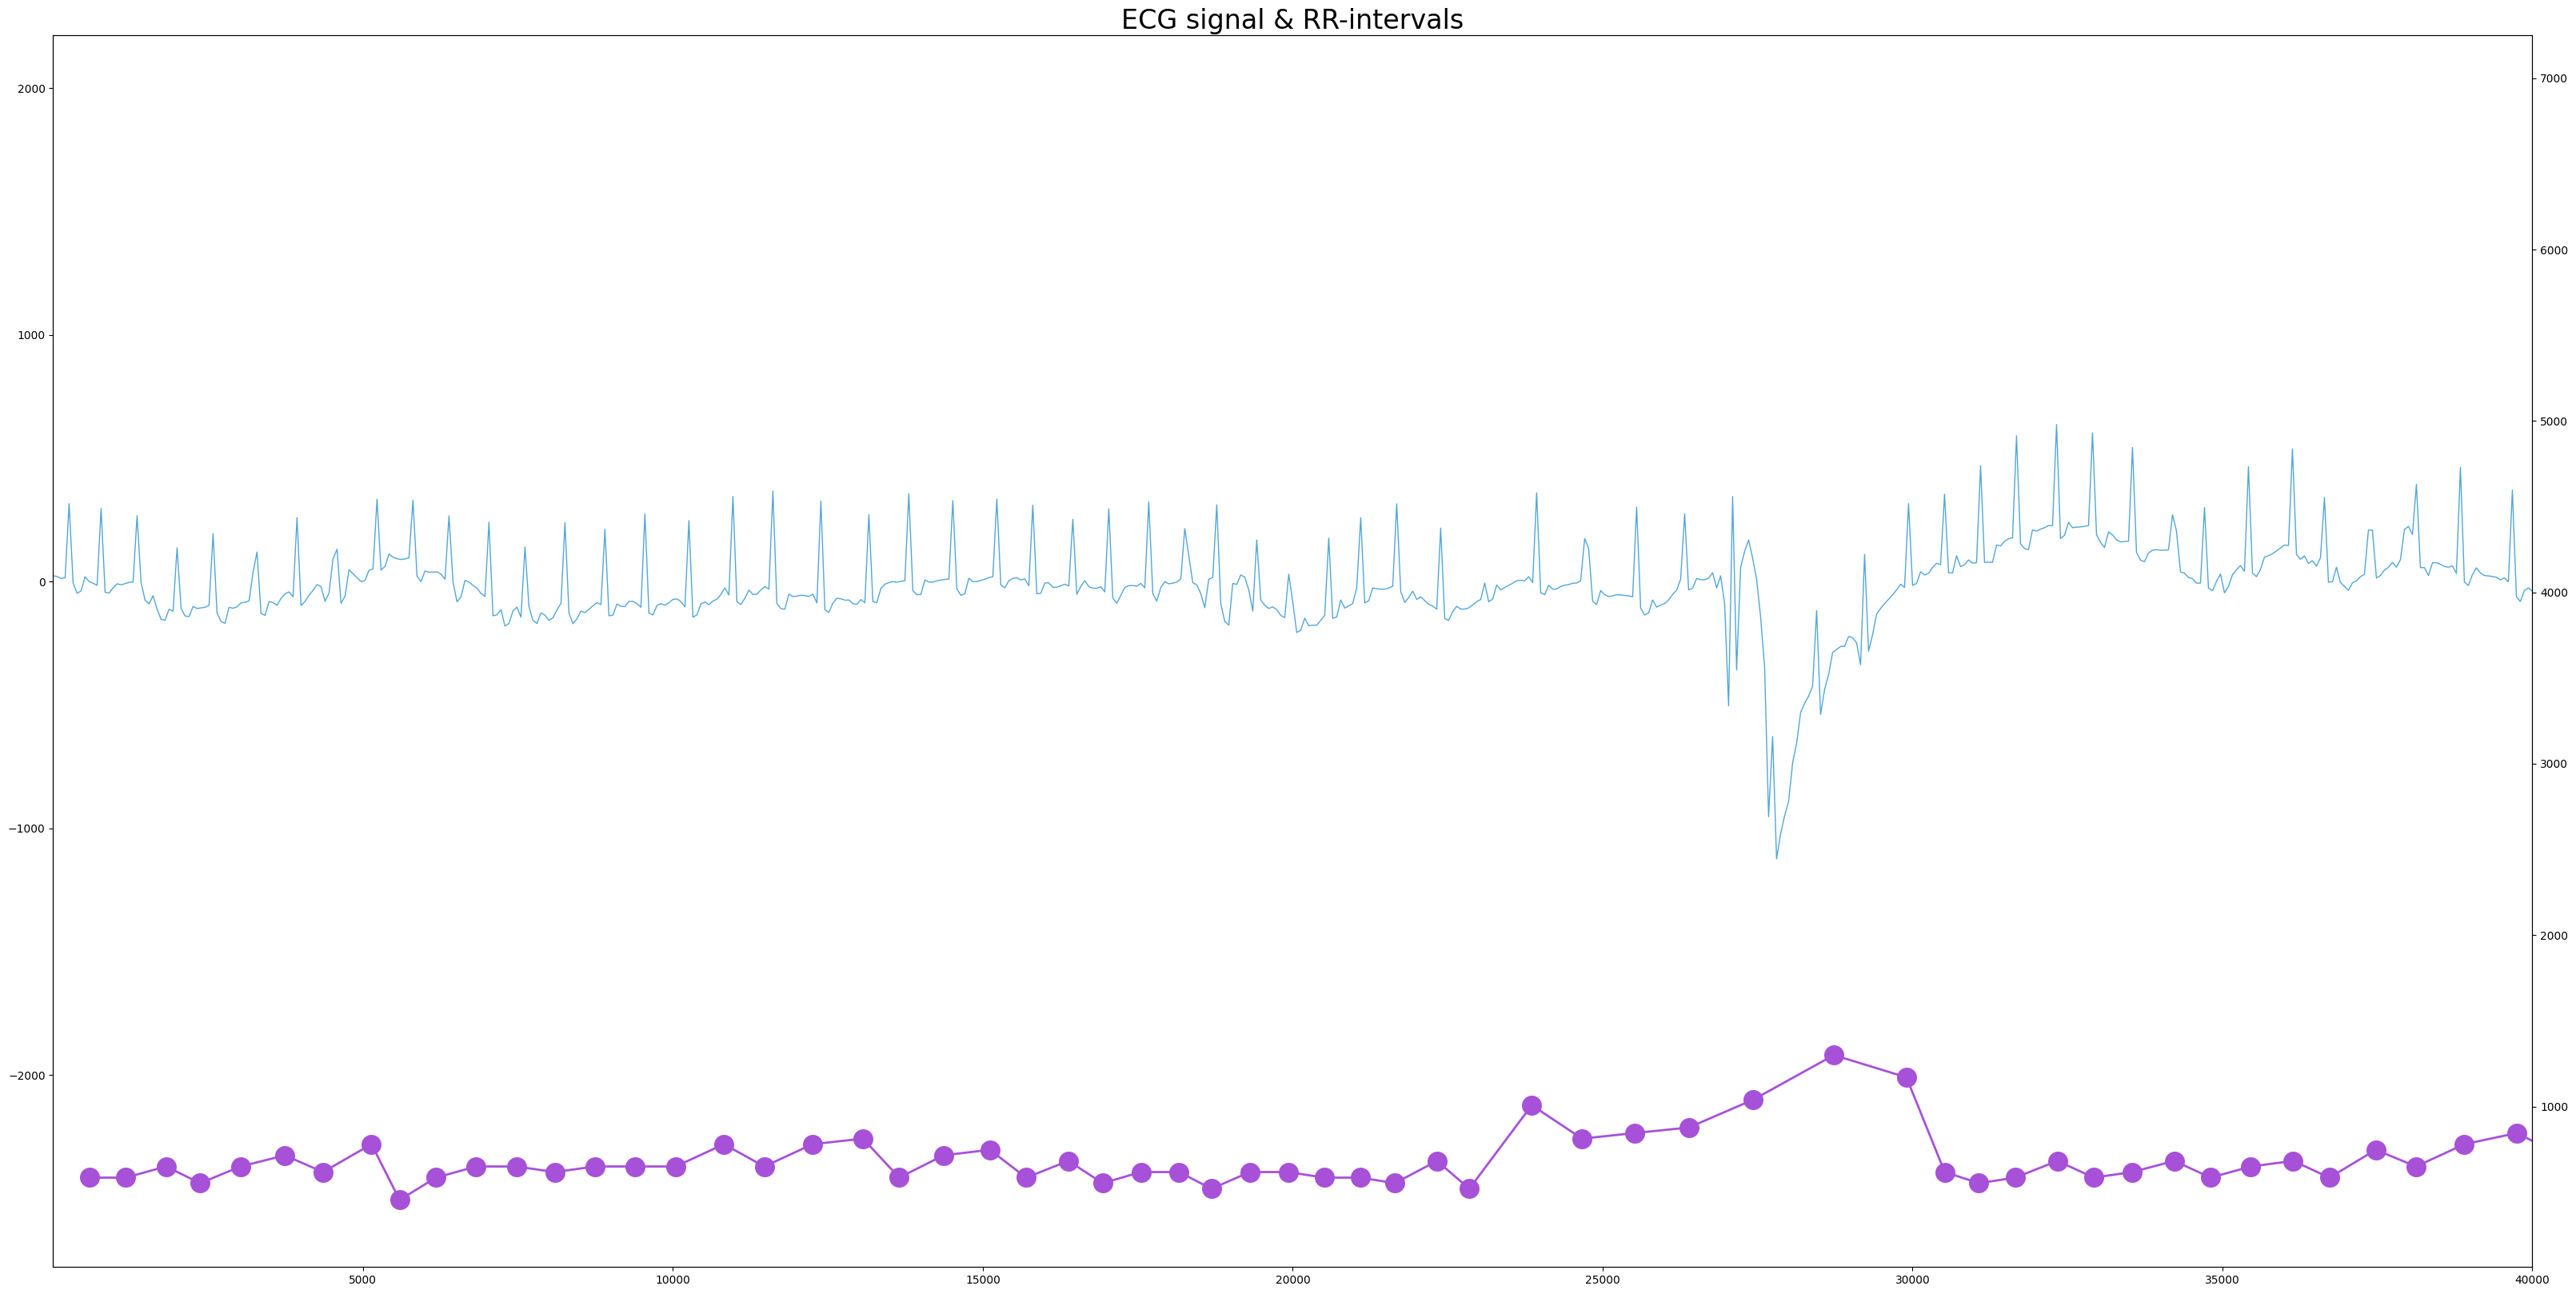

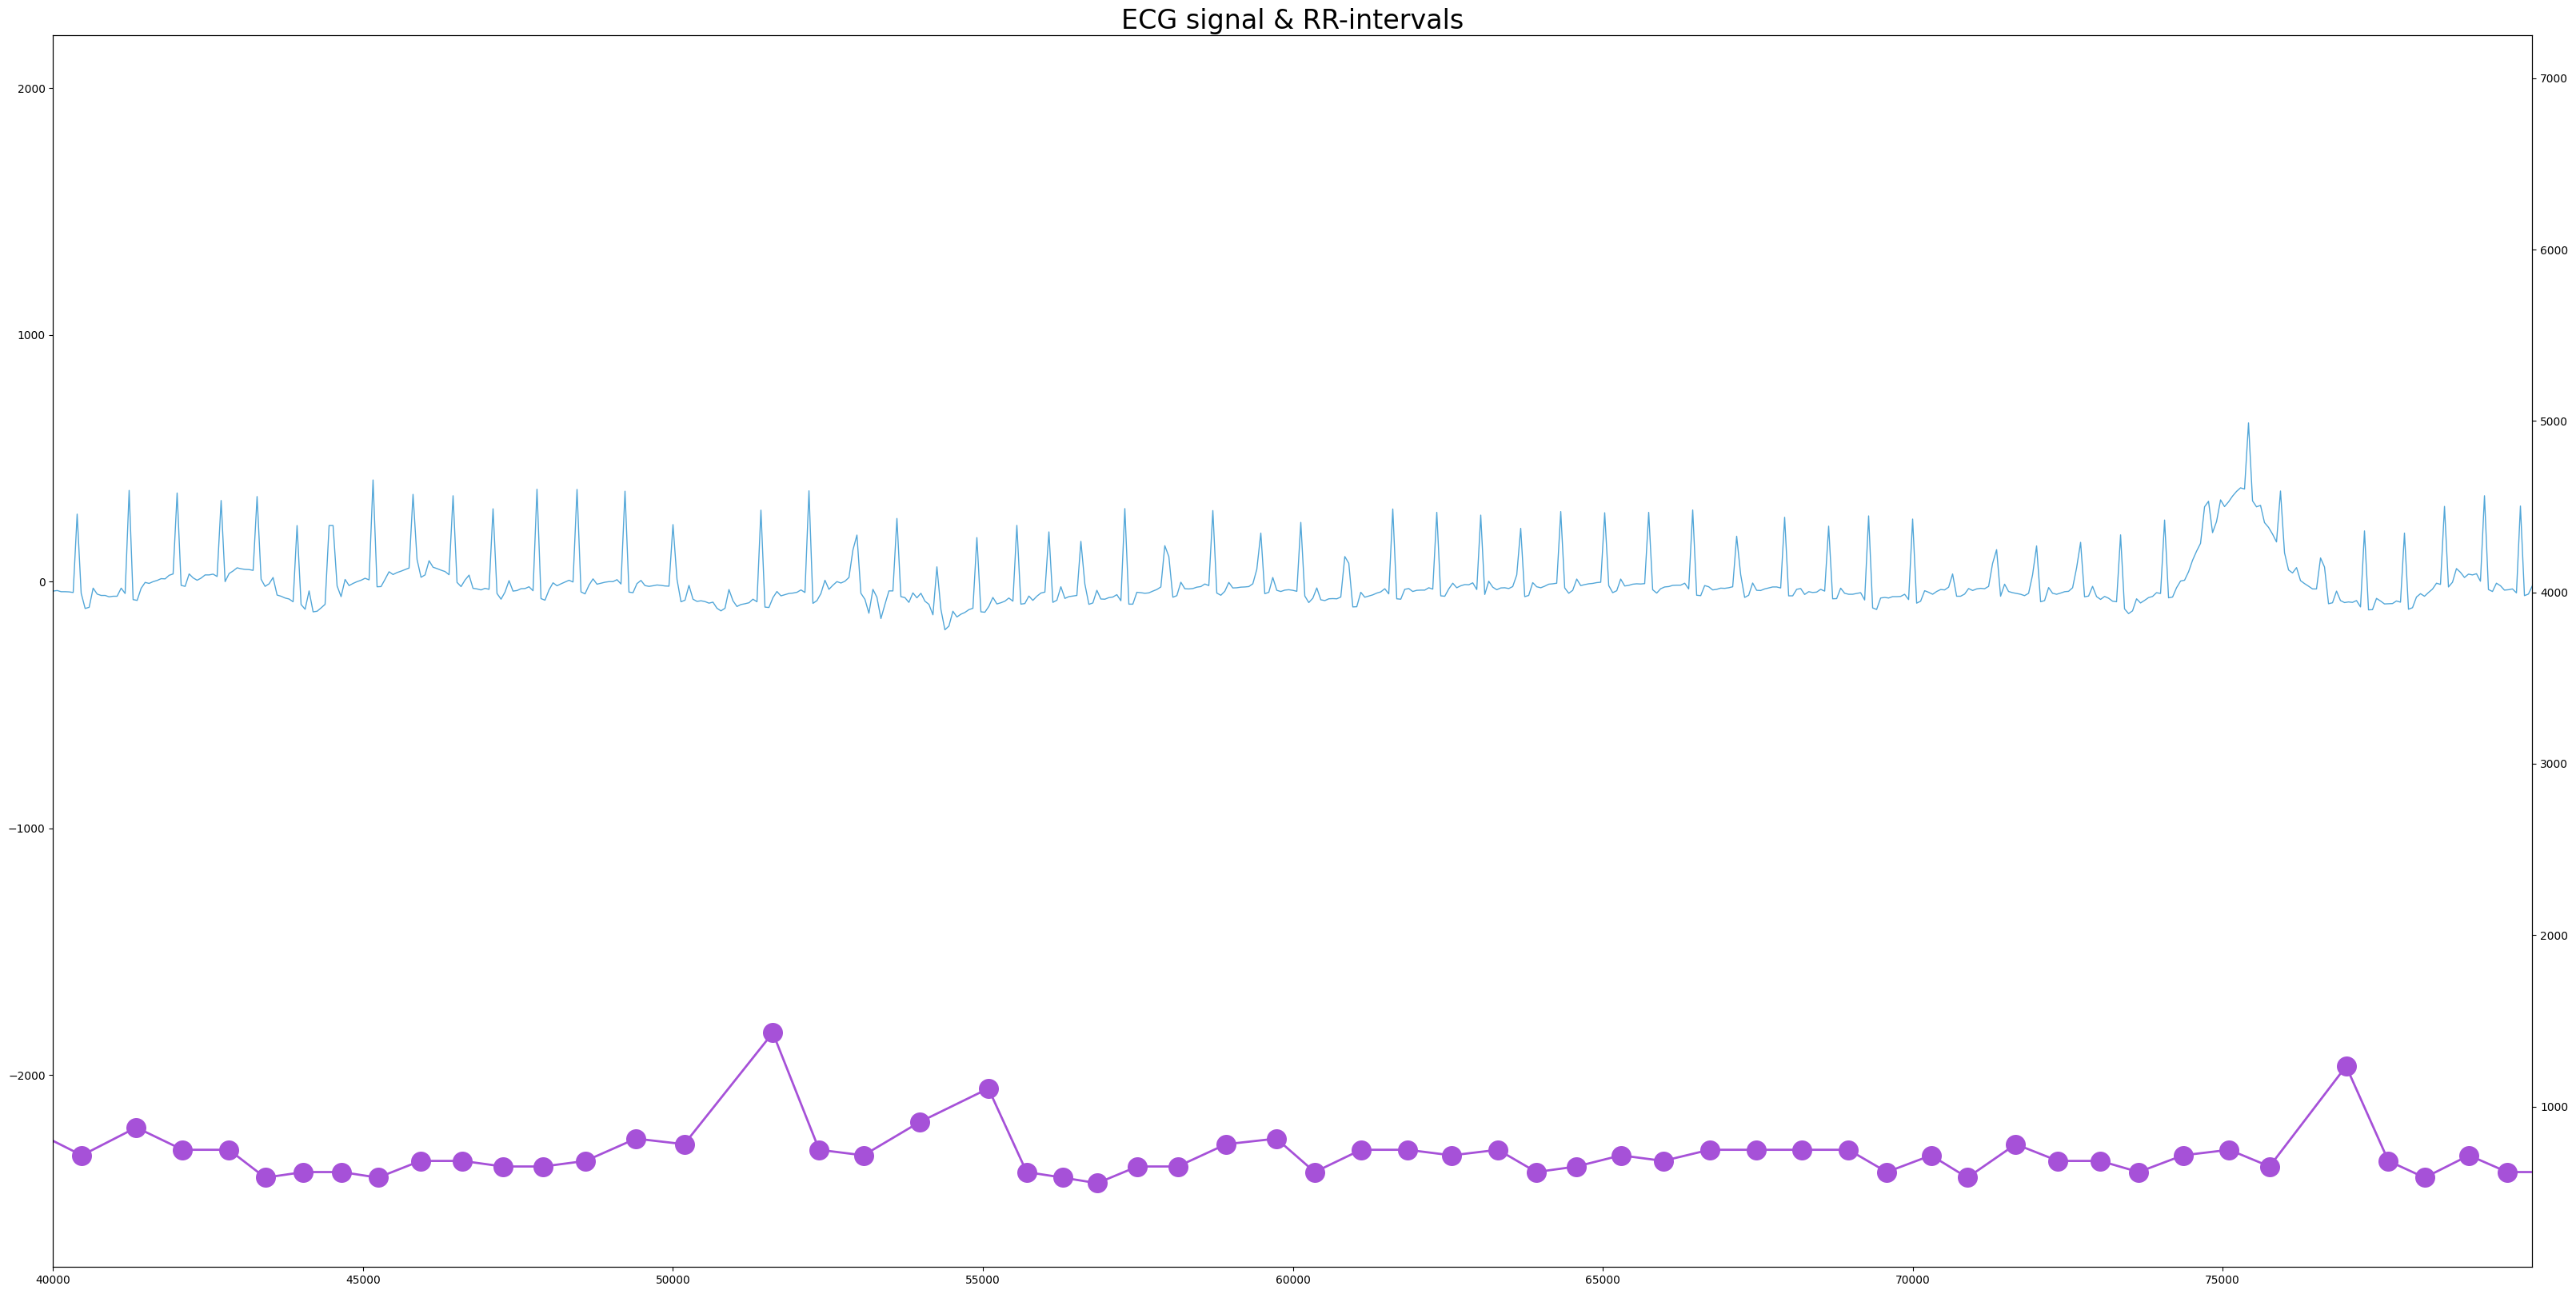

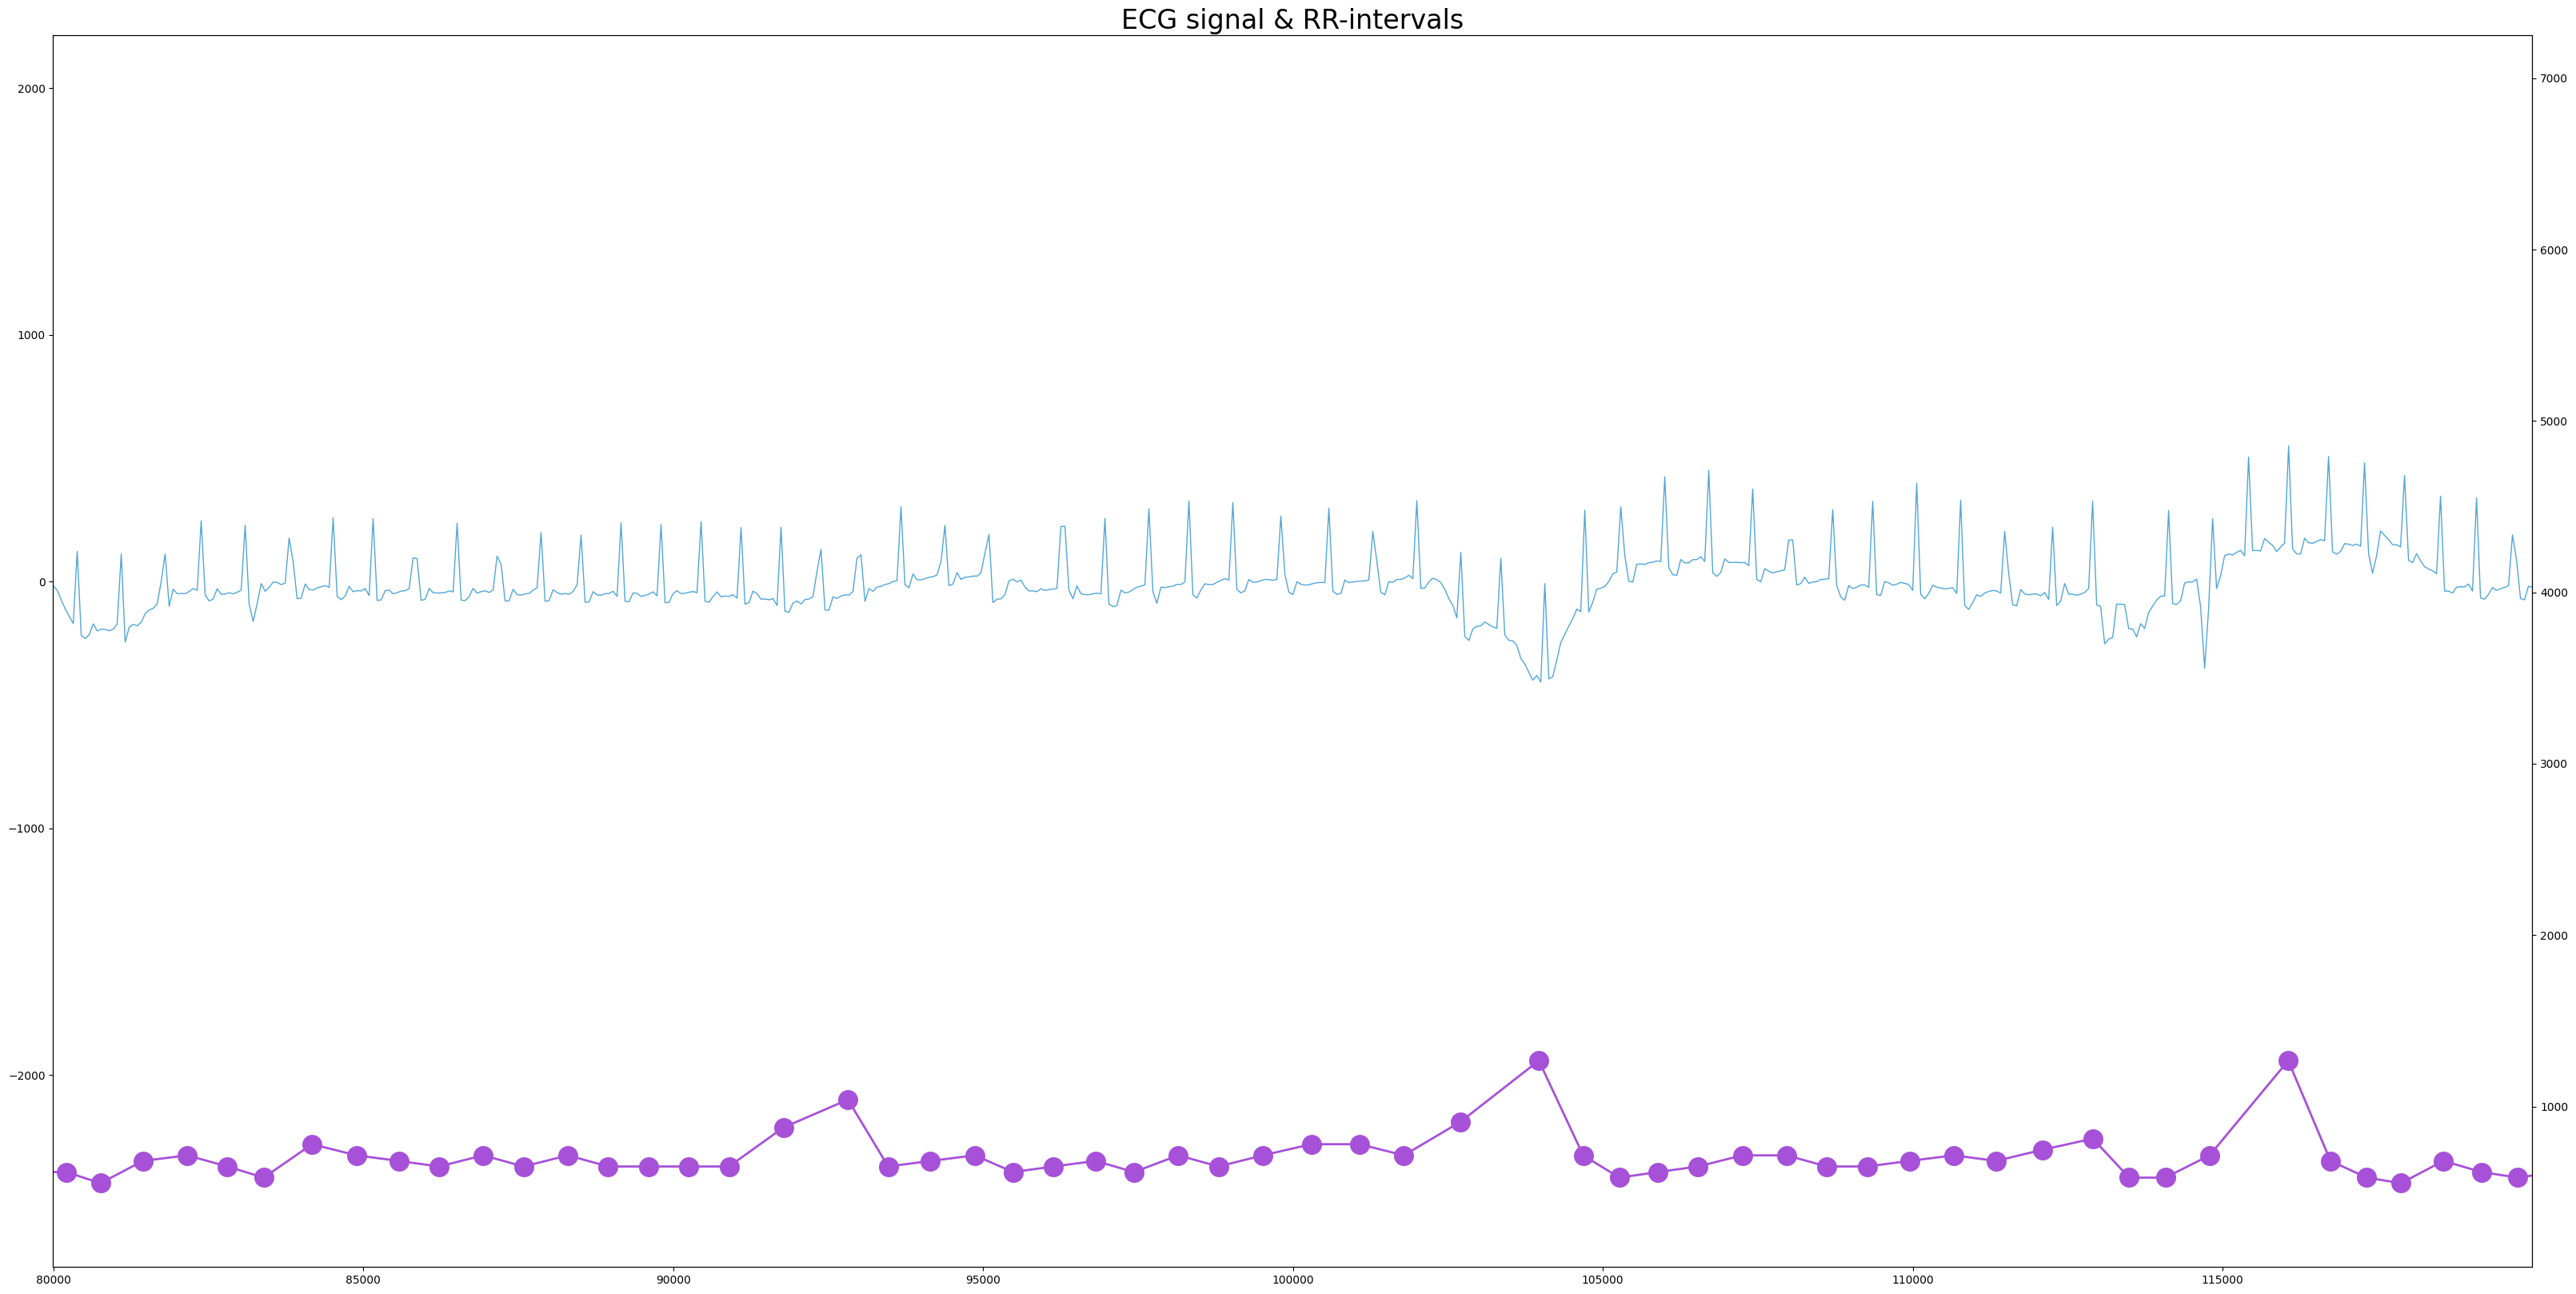

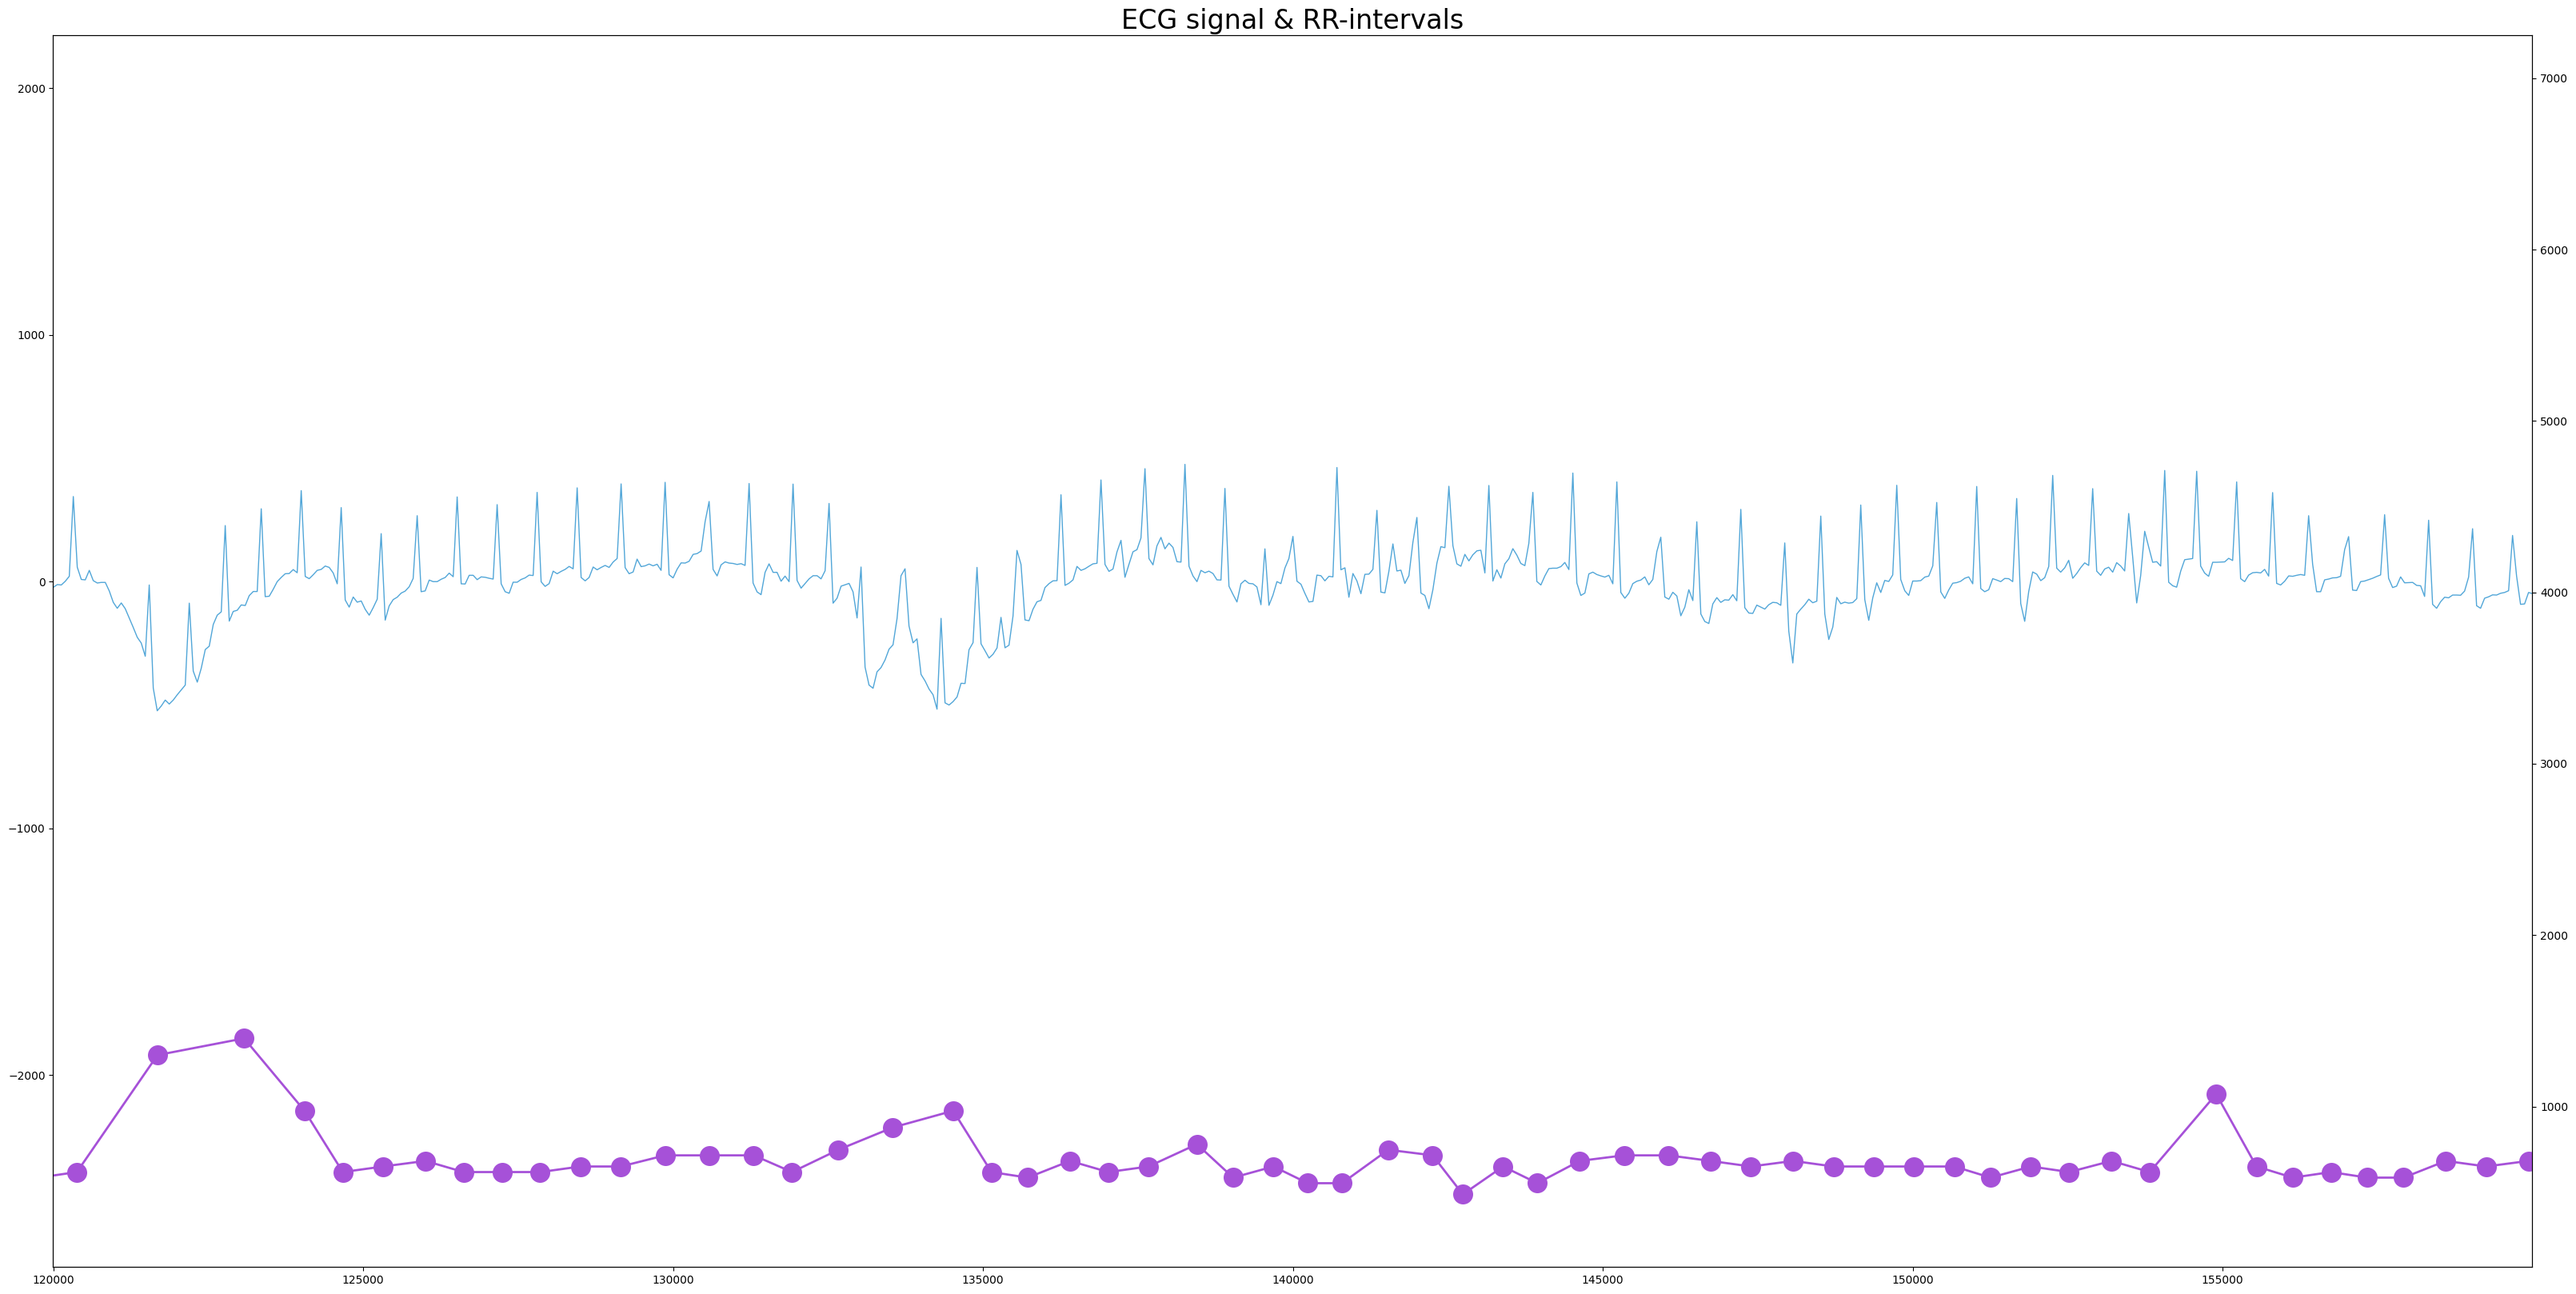

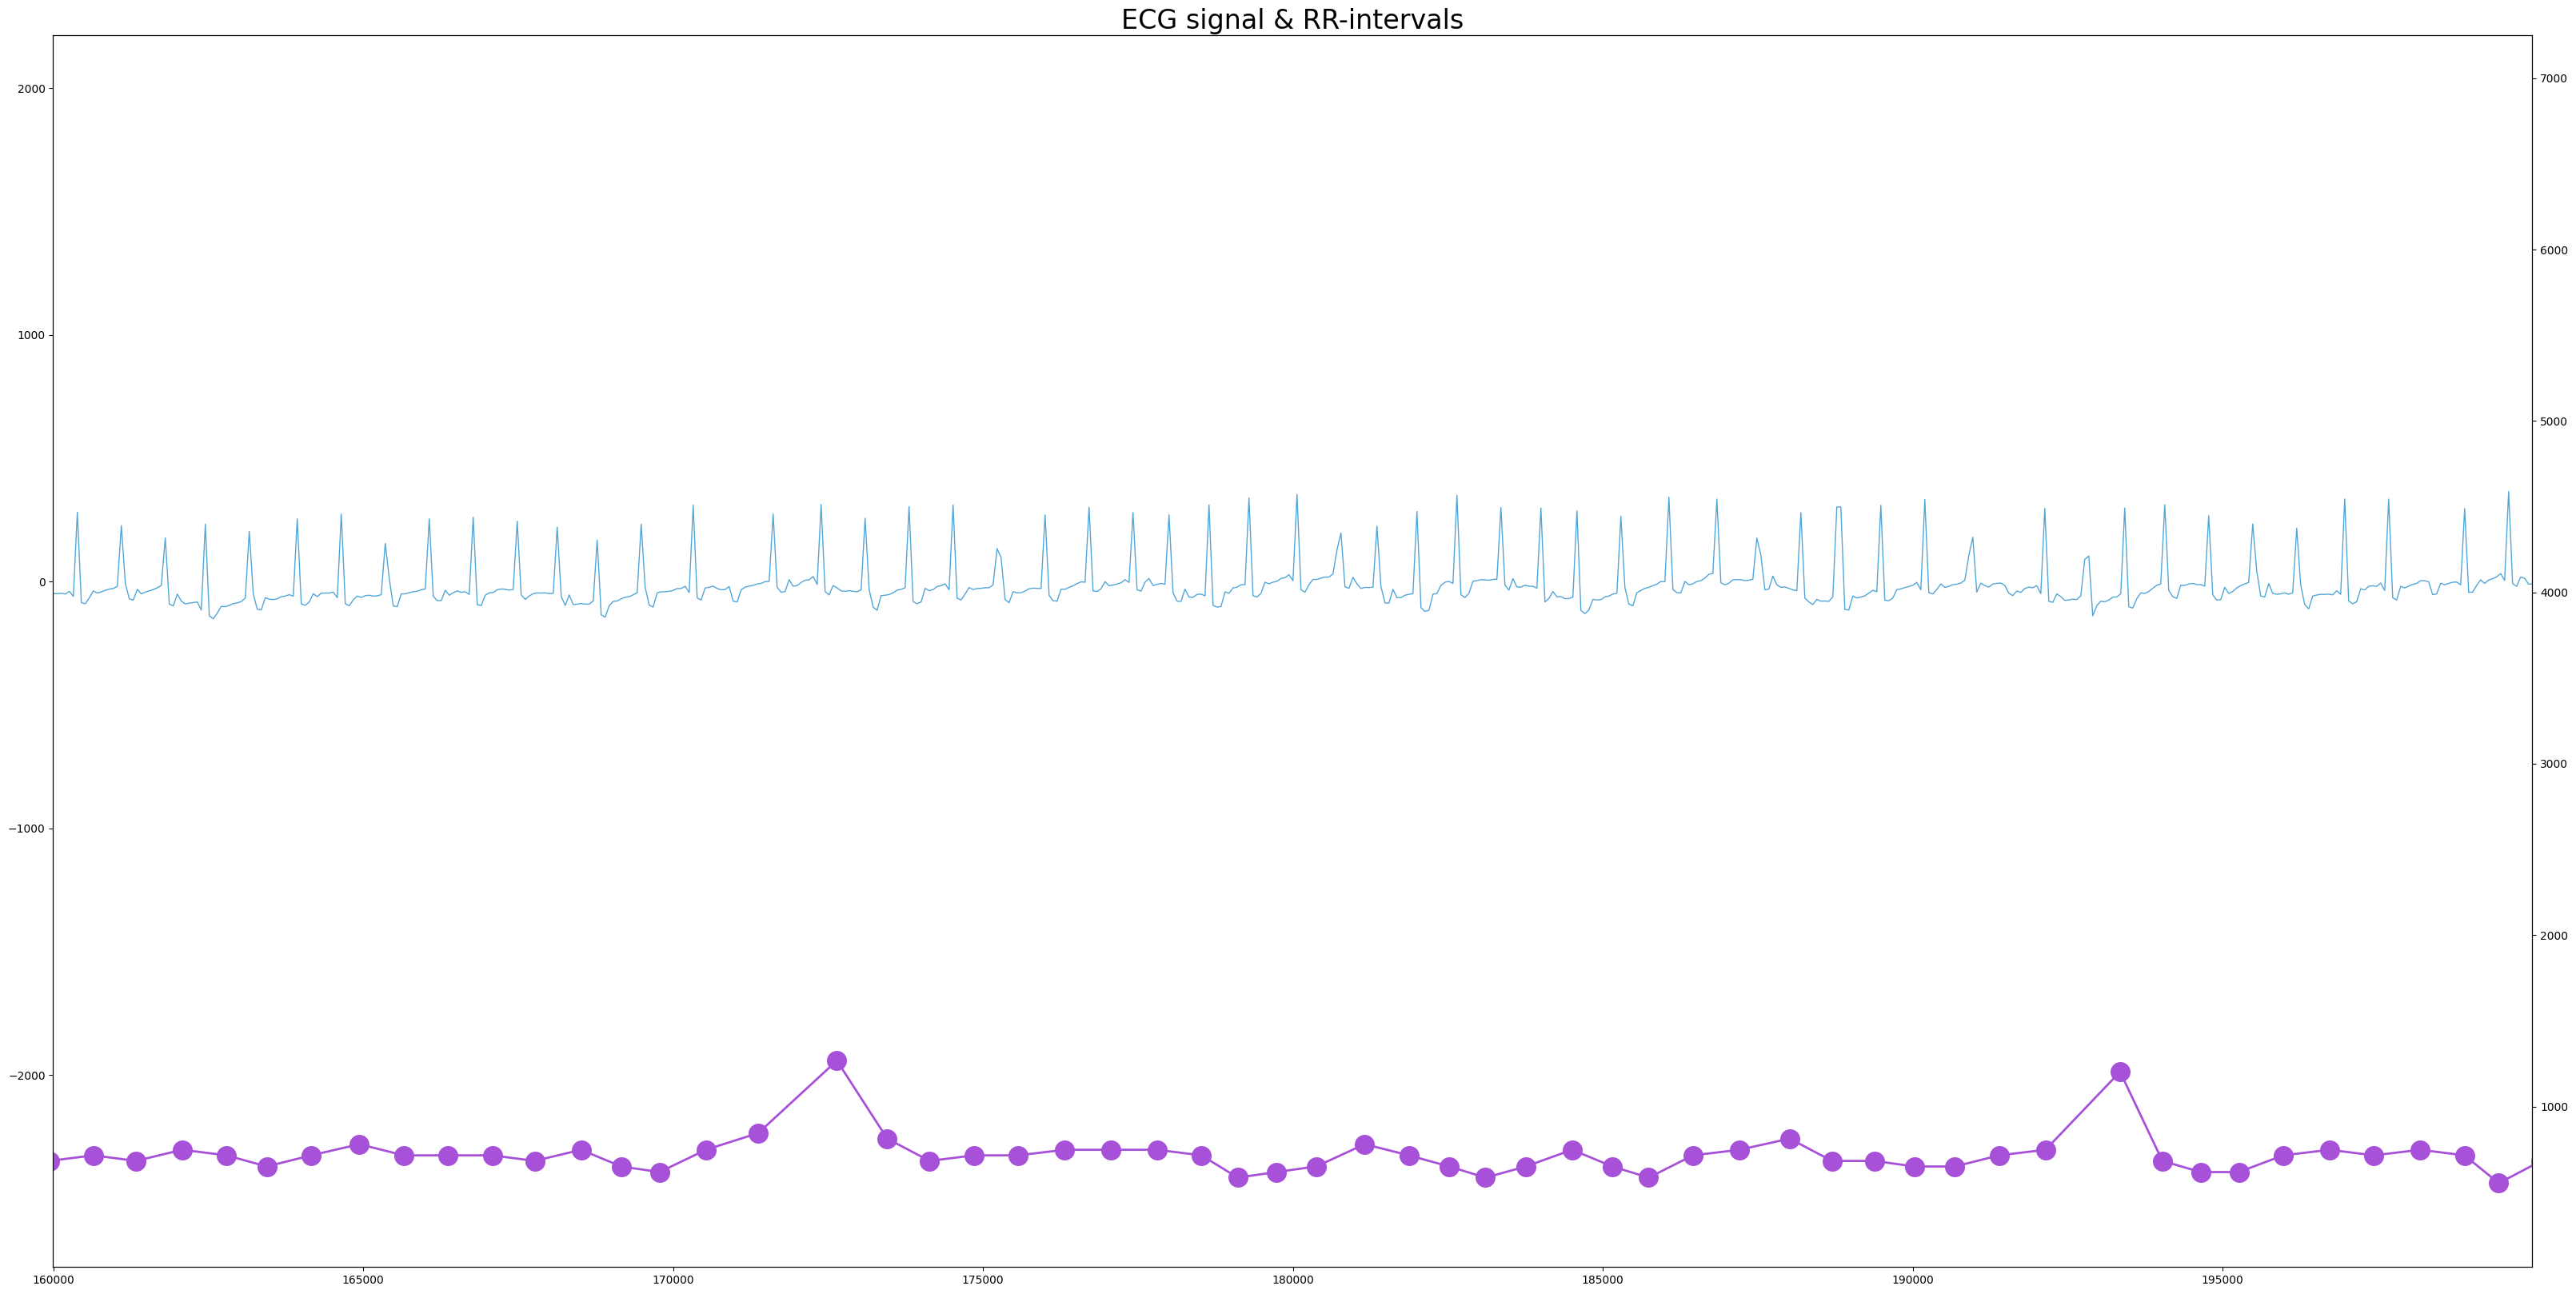

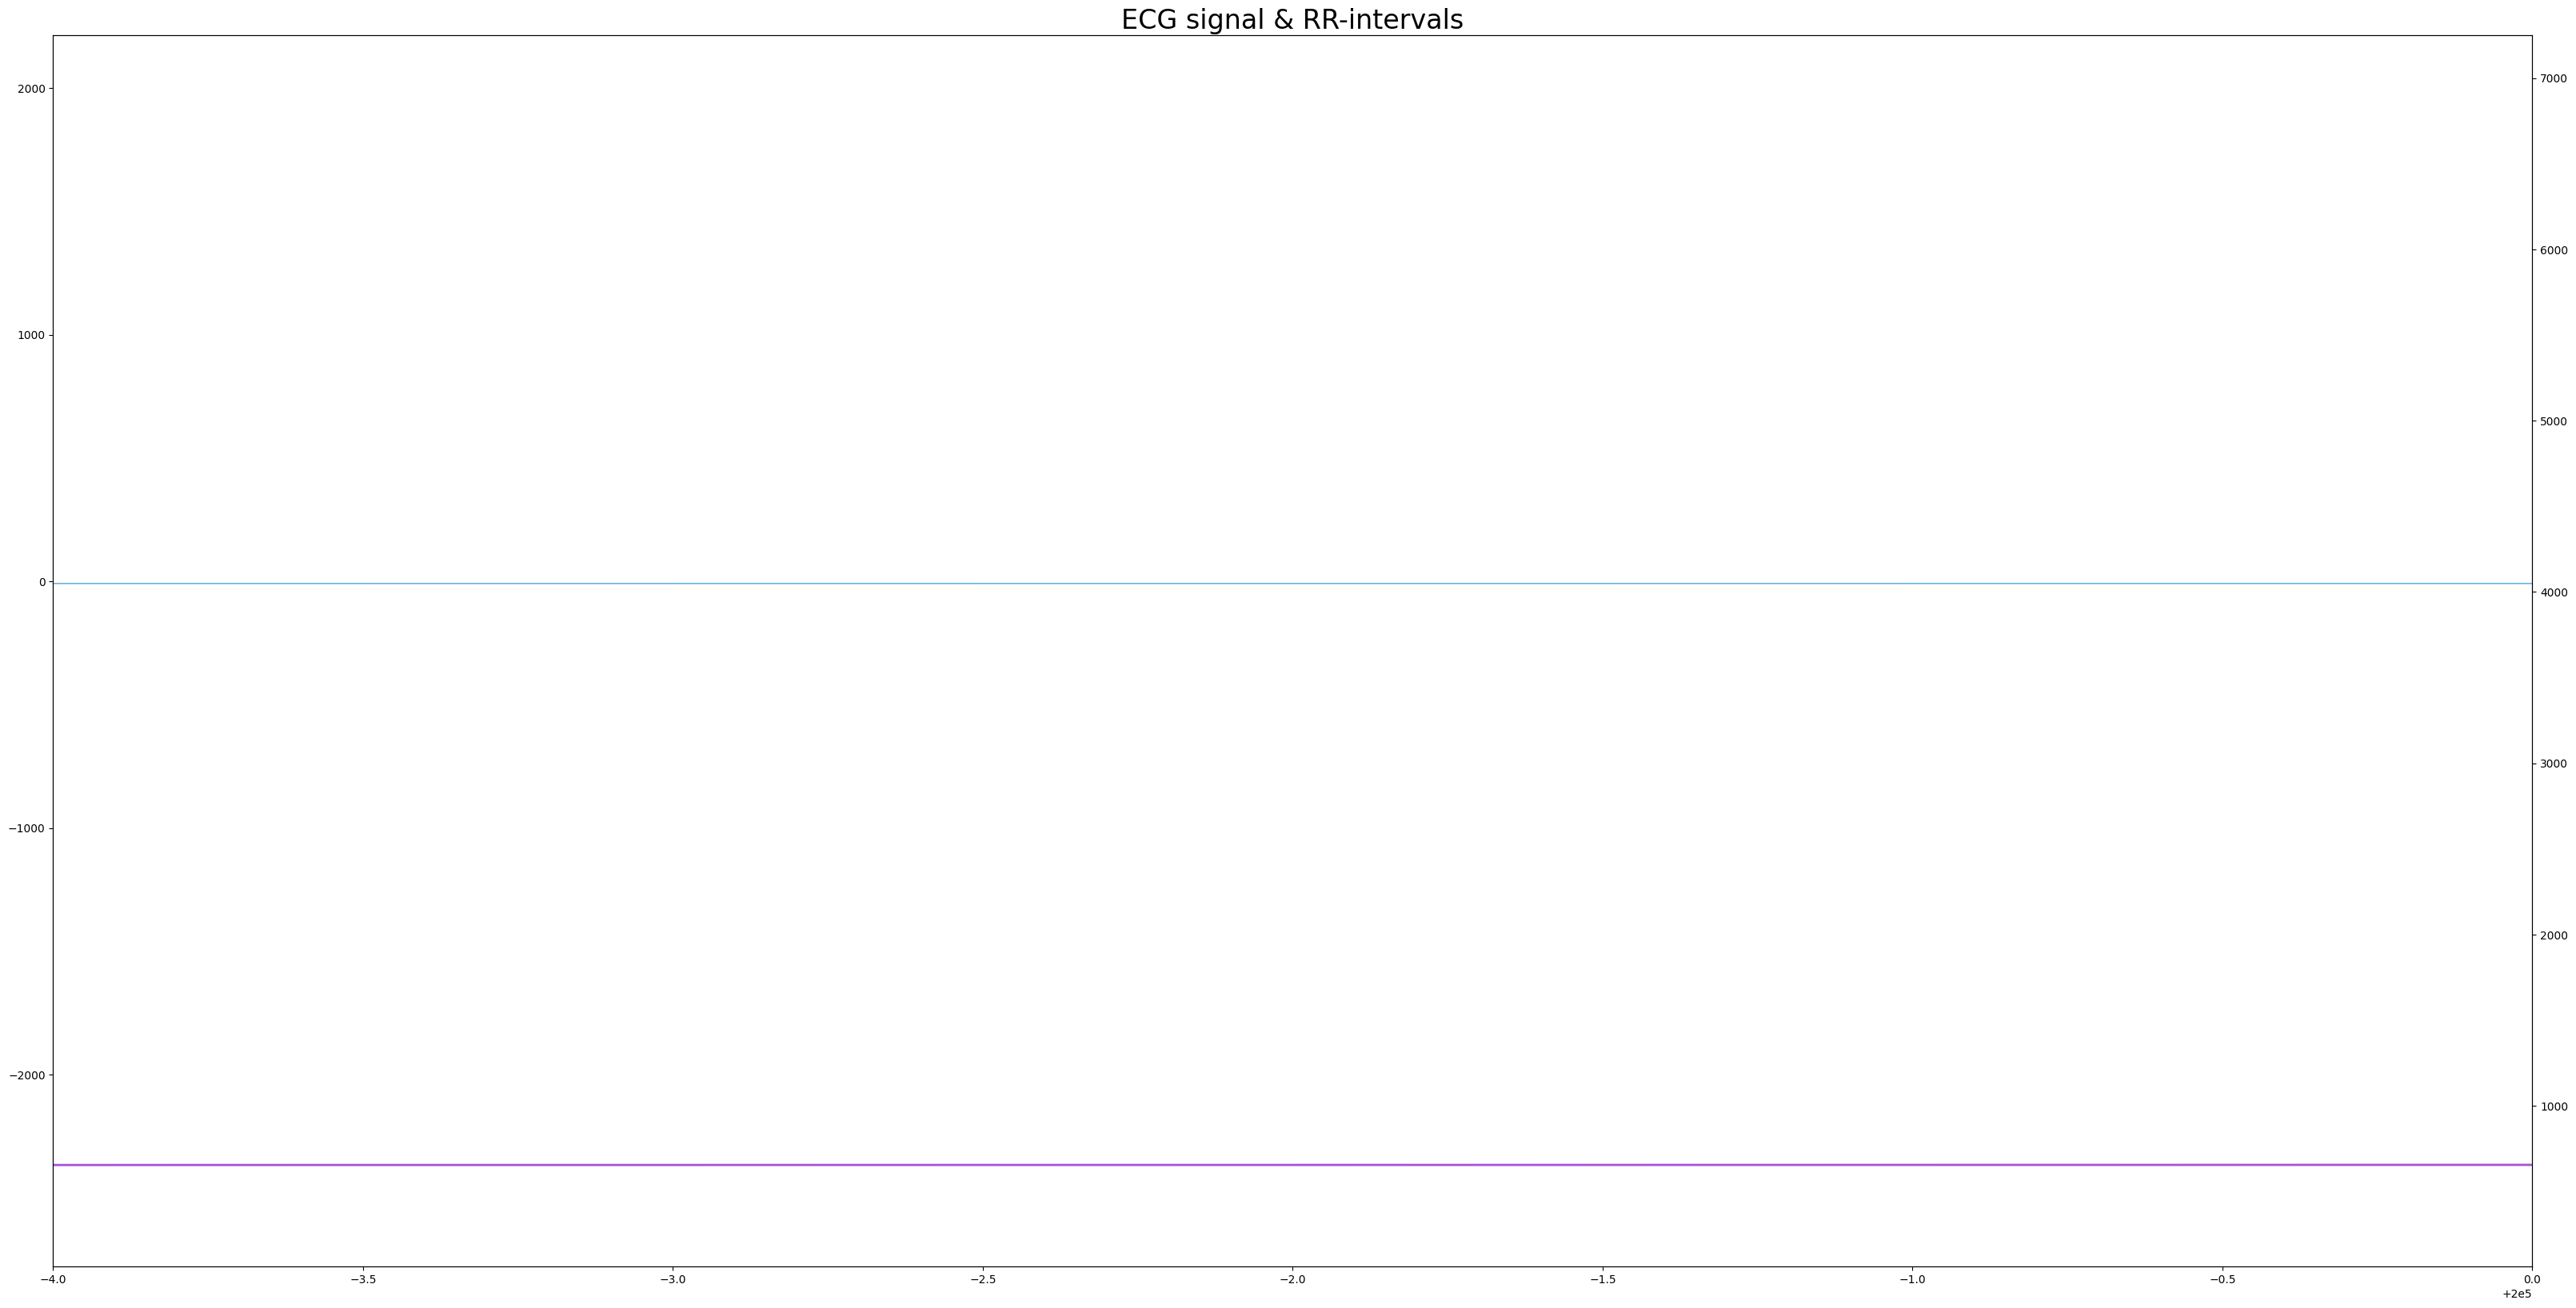

In [13]:
sampfrom =1
sampto = 200000
nr_plots = 5

t = np.linspace(1.5 * np.pi, 3.5 * np.pi,13)    # 13(Length of QRS filter, Tunable)
qrs_filter = -np.sin(t)
peaks, similarity = detect_peaks(df.ECG, threshold=0.03,qrs_filter=qrs_filter)  #Threshold(tunable)
# plt.plot(similarity[1000:1100])
# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks,threshold=5)
# print(grouped_peaks)
final=[element * 65 for element in grouped_peaks]
rr = np.diff(final)
final=np.array(final)
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.title("ECG signal & RR-intervals", fontsize=24)
    plt.plot(df.Elapsedtime, -800*df.ECG, label="ECG", color="#51A6D8", linewidth=1)
    # plt.plot(final, np.repeat(600, final.shape[0]), markersize=14, label="Found peaks", color="orange", marker="o", linestyle="None")
    # plt.legend(loc="upper left", fontsize=20)
    # plt.xlabel("Time (milliseconds)", fontsize=16)
    # plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    # plt.gca().set_ylim(400, 800)

    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    ax2.set_xlim(start, stop)
    # ax2.set_ylim(-2000, 2000)
    # ax2.legend(loc="upper right", fontsize=20)

    # plt.xlabel("Time (ms)", fontsize=16)
    # plt.ylabel("RR-interval (ms)", fontsize=16)

    # plt.savefig(os.path.join(output_path, "ecg-with-rr-%s-%s.png" % (start, stop)))